In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/young-adults-affective-data-ecg-and-gsr-signals/ECG_GSR_Emotions/Stimulus_Description.xlsx
/kaggle/input/young-adults-affective-data-ecg-and-gsr-signals/ECG_GSR_Emotions/Self-Annotation Labels/Self-annotation Multimodal.xlsx
/kaggle/input/young-adults-affective-data-ecg-and-gsr-signals/ECG_GSR_Emotions/Self-Annotation Labels/ReadME.txt
/kaggle/input/young-adults-affective-data-ecg-and-gsr-signals/ECG_GSR_Emotions/Self-Annotation Labels/Self-annotation Single Modal.xlsx
/kaggle/input/young-adults-affective-data-ecg-and-gsr-signals/ECG_GSR_Emotions/Self-Annotation Labels/Self-annotation Single Modal_Use.xlsx
/kaggle/input/young-adults-affective-data-ecg-and-gsr-signals/ECG_GSR_Emotions/Self-Annotation Labels/Self-annotation Multimodal_Use.xlsx
/kaggle/input/young-adults-affective-data-ecg-and-gsr-signals/ECG_GSR_Emotions/Raw Data/Single Modal/ECG/ECGdata_s3p12v3.dat
/kaggle/input/young-adults-affective-data-ecg-and-gsr-signals/ECG_GSR_Emotions/Raw Data/Single Modal/ECG/ECGd

In [2]:
!pip install wget
!pip install PyGithub
!pip install openpyxl

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=54dea346f495c52ca93b4c410d53704f1b9531e9ab0d966bc15fc21223e4cd2b
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.4/293.4 kB 526.4 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 3.1 MB/s eta 0:00:00a 0:00:01


In [3]:
import os
from os import path

import glob
import pandas as pd
import numpy as np
import wget
from github import Github
import shutil

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

import tensorflow as tf

# signal processing
from scipy import signal
from scipy.ndimage import label as sci_label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz

# misc
import warnings

In [4]:
# remove all existing csv files
! rm *.csv
! rm *.xlsx


if path.exists('/kaggle/working/Raw Data') == True:
  shutil.rmtree("/kaggle/working/Raw Data")

if path.exists('/kaggle/working/Raw Data/Multimodal/ECG/') == False:
  os.mkdir('Raw Data')
  os.mkdir('Raw Data/Multimodal')
  os.mkdir('Raw Data/Multimodal/ECG')
  


if path.exists('/kaggle/working/Raw Data/Single Modal/ECG') == False:
  os.mkdir('Raw Data/Single Modal')
  os.mkdir('Raw Data/Single Modal/ECG')

!pwd
!ls

rm: cannot remove '*.csv': No such file or directory
rm: cannot remove '*.xlsx': No such file or directory
/kaggle/working
'Raw Data'   __notebook_source__.ipynb


In [5]:
stimulus_desc_file = pd.read_excel('../input/young-adults-affective-data-ecg-and-gsr-signals/ECG_GSR_Emotions/Stimulus_Description.xlsx')
stimulus_desc_file.to_csv('Stimulus_Description.csv', index = None, header=True)
stimulus_desc = pd.read_csv('Stimulus_Description.csv')
#stimulus_desc.head()

In [6]:
self_annotation_multimodal_file = pd.read_excel('../input/young-adults-affective-data-ecg-and-gsr-signals/ECG_GSR_Emotions/Self-Annotation Labels/Self-annotation Multimodal_Use.xlsx')
self_annotation_multimodal_file.to_csv('Self-annotation Multimodal_Use.csv', index = None, header=True)
self_annotation_multimodal = pd.read_csv('Self-annotation Multimodal_Use.csv')
self_annotation_multimodal['annotation'] = 'M'
self_annotation_multimodal.rename(columns = {'V_Label':'Valence', 'A_Label':'Arousal', 'Four_Labels':'Four_Label'}, inplace = True)
#self_annotation_multimodal.head()

In [8]:
self_annotation_singlemodal_file = pd.read_excel('../input/young-adults-affective-data-ecg-and-gsr-signals/ECG_GSR_Emotions/Self-Annotation Labels/Self-annotation Single Modal_Use.xlsx')
self_annotation_singlemodal_file.to_csv('Self-annotation Single Modal_Use.csv', index = None, header=True)
self_annotation_singlemodal = pd.read_csv('Self-annotation Single Modal_Use.csv')
self_annotation_singlemodal['annotation'] = 'S'
self_annotation_singlemodal.rename(columns = {'Male':'Gender', 'Session Id':'Session ID', 'Video Id':'Video ID'}, inplace = True)
#self_annotation_singlemodal.head()

In [10]:
self_annotation_frames = [self_annotation_multimodal, self_annotation_singlemodal]
merged_dataframe = pd.concat(self_annotation_frames)
#merged_dataframe.head()
#merged_dataframe.tail()
table_frame = merged_dataframe.copy()

In [12]:
cols = []
cols.append('Raw Data')
for col in merged_dataframe.columns:
    cols.append(col)

In [13]:
arr_shape = 1000
raw_data_arr = []

def form_data(data_array = [], annotation = '', data_path = ''):
    #######
    #
    #     If anyone could help me improve this code please do so.
    #     Goals was to product the same data format of raw_dataframe DF below.
    #
    #######
    for filename in os.listdir(data_path):
            data = np.loadtxt(os.path.join(data_path, filename), delimiter=',')
            data = data[0:arr_shape]
            filenames = filename.split('ECGdata_')[1]
            filenames = filenames.split('.dat')[0]
            filenames = filenames.lower()
            s = filenames.split('s')[1].split('p');
            p = s[1].split('v')
            s = s[0]
            v = p[1]
            p = p[0]
            data_row = merged_dataframe.loc[(merged_dataframe['Session ID'] == int(s)) & 
                             (merged_dataframe['Participant Id'] == int(p)) & 
                             (merged_dataframe['Video ID'] == int(v)) &
                             (merged_dataframe['annotation'] == 'M')]
            stim_row = stimulus_desc.loc[(stimulus_desc['Session ID'] == int(s)) & 
                             (stimulus_desc['Video ID'] == int(v))]
            for index, row in data_row.iterrows():
              data_array.append([data, 
                                   row['Participant Id'], row['Session ID'], row['Video ID'],
                                   row['Name'], row['Age'], row['Gender'], row['Valence level'],
                                   row['Arousal level'], row['Dominance level'], row['Happy'],
                                   row['Sad'], row['Fear'], row['Anger'], row['Neutral'],
                                   row['Disgust'], row['Surprised'], row['Familiarity Score'],
                                   row['Emotion'], row['Valence'], row['Arousal'], row['Four_Label'],
                                   row['annotation'],  stim_row['Target Emotion'].iat[0]
                                   ])
    return data_array

    
raw_data_arr =  form_data(data_array = raw_data_arr, annotation = 'M', data_path = "../input/young-adults-affective-data-ecg-and-gsr-signals/ECG_GSR_Emotions/Raw Data/Multimodal/ECG/")
raw_data_arr =  form_data(data_array = raw_data_arr, annotation = 'S', data_path = "../input/young-adults-affective-data-ecg-and-gsr-signals/ECG_GSR_Emotions/Raw Data/Single Modal/ECG/")
cols.append('Target Emotion')
raw_dataframe = pd.DataFrame(raw_data_arr, columns = cols)
raw_dataframe.rename(columns = {'Participant Id':'Participant ID', 'annotation':'Modal', 'Four_Label':'Four label'}, inplace = True)
raw_dataframe['Familiarity Score'] = raw_dataframe['Familiarity Score'].fillna('Never watched')
raw_dataframe = raw_dataframe.replace(np.nan, '', regex=True)
#raw_dataframe.head()

In [14]:
plot_frame = raw_dataframe.copy()
#plot_frame.head()

In [16]:
plot_frame = plot_frame.drop(['Participant ID', 'Session ID', 'Familiarity Score', 'Age', 'Gender', 'Name'], axis = 1)
sad_data = plot_frame.loc[(plot_frame['Emotion'] == 'Sad') & (plot_frame['Target Emotion'] == 'sad')] 
fear_data = plot_frame.loc[(plot_frame['Emotion'] == 'Fear')  & (plot_frame['Target Emotion'] == 'fear')]
happy_data = plot_frame.loc[(plot_frame['Emotion'] == 'Happy') & (plot_frame['Target Emotion'] == 'happy')]
anger_data = plot_frame.loc[(plot_frame['Emotion'] == 'Anger') & (plot_frame['Target Emotion'] == 'anger')]
neutral_data = plot_frame.loc[(plot_frame['Emotion'] == 'Neutral') & (plot_frame['Target Emotion'] == 'neutral')]
mixed_data = plot_frame.loc[(plot_frame['Emotion'] == 'Mixed') & (plot_frame['Target Emotion'] == 'neutral')]
disgust_data = plot_frame.loc[(plot_frame['Emotion'] == 'Disgust') & (plot_frame['Target Emotion'] == 'disgust')]
surprised_data = plot_frame.loc[(plot_frame['Emotion'] == 'Surprise') & (plot_frame['Target Emotion'] == 'surprise')]

KeyError: "['Participant ID' 'Session ID' 'Familiarity Score' 'Age' 'Gender' 'Name'] not found in axis"

In [17]:
def plot_signals(data_arr, title = ''):
    plt.clf()
    plt.figure(figsize=(12, 4))
    
    for index, row in data_arr.iterrows():
        y = row['Raw Data']
        plt.plot(y)
        #x = np.arange(y.size)
        #plt.plot(x, y)
    
    plt.tight_layout()
    plt.title(title)
    plt.show()

<Figure size 432x288 with 0 Axes>

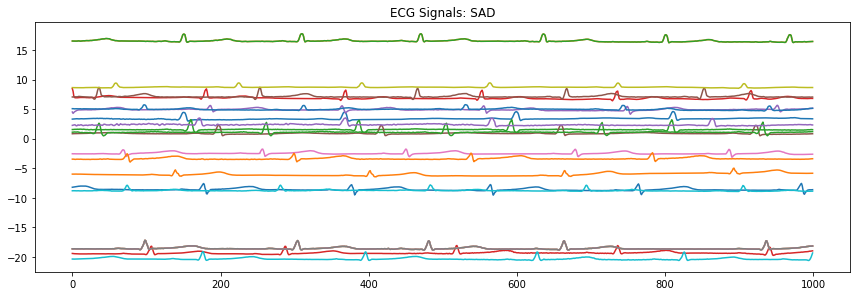

In [18]:
plot_signals(data_arr = sad_data, title = 'ECG Signals: SAD')

<Figure size 432x288 with 0 Axes>

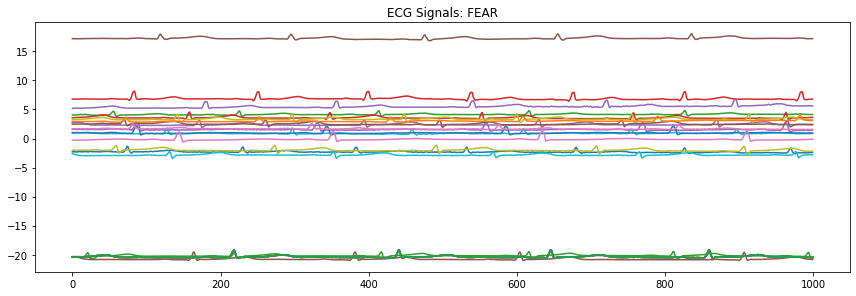

In [19]:
plot_signals(data_arr = fear_data, title = 'ECG Signals: FEAR')

<Figure size 432x288 with 0 Axes>

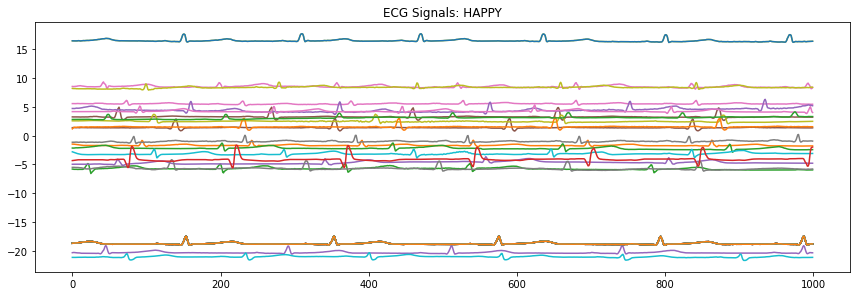

In [20]:
plot_signals(data_arr = happy_data, title = 'ECG Signals: HAPPY')

<Figure size 432x288 with 0 Axes>

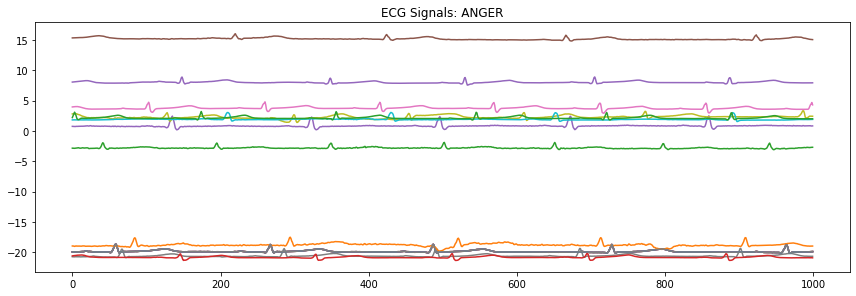

In [21]:
plot_signals(data_arr = anger_data, title = 'ECG Signals: ANGER')

<Figure size 432x288 with 0 Axes>

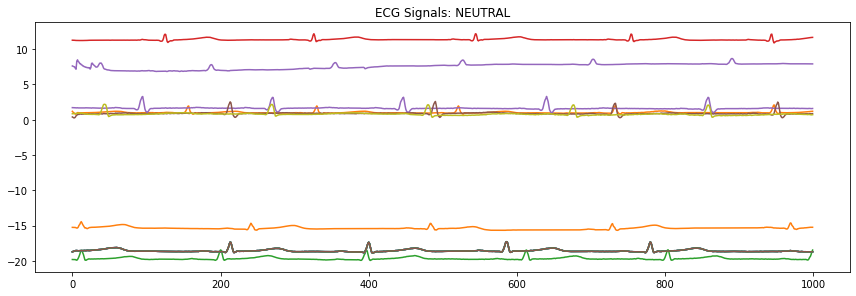

In [22]:
plot_signals(data_arr = neutral_data, title = 'ECG Signals: NEUTRAL')

<Figure size 432x288 with 0 Axes>

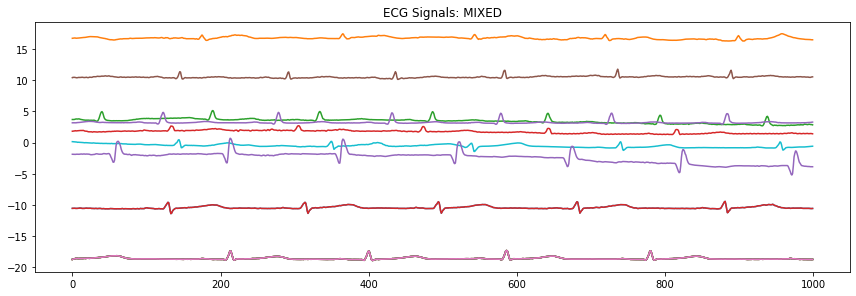

In [23]:
plot_signals(data_arr = mixed_data, title = 'ECG Signals: MIXED')

<Figure size 432x288 with 0 Axes>

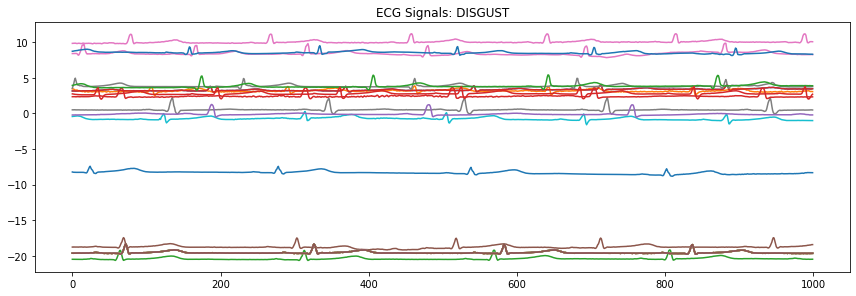

In [24]:
plot_signals(data_arr = disgust_data, title = 'ECG Signals: DISGUST')

<Figure size 432x288 with 0 Axes>

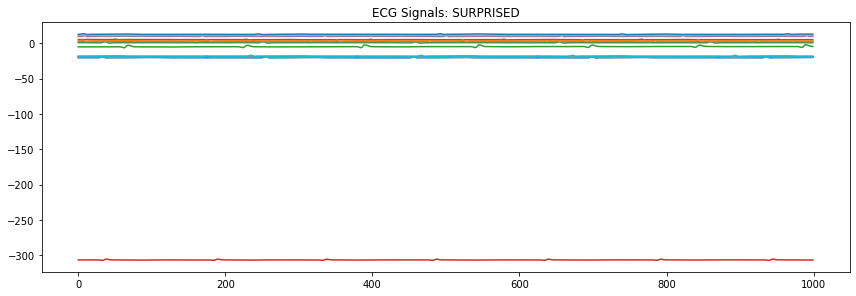

In [25]:
plot_signals(data_arr = surprised_data, title = 'ECG Signals: SURPRISED')

In [27]:
#train_d_frame = plot_frame.copy().drop(['Video ID', 'Valence level', 'Arousal level',
#                                        'Dominance level', 'Happy', 'Sad', 'Fear',
#                                        'Anger', 'Neutral', 'Disgust', 'Surprised',
#                                        'Valence', 'Arousal', 'Four label', 'Modal'
#                                       ], axis = 1)
train_d_frame = plot_frame.copy().drop(['Video ID', 'Happy', 'Sad', 'Fear',
                                        'Anger', 'Neutral', 'Disgust', 'Surprised', 'Four label', 'Modal'
                                       ], axis = 1)
train_d_frame.rename(columns = {'Raw Data':'feature', 'Emotion':'emotion'}, inplace = True)
#train_d_frame.head()

In [28]:
from __future__ import division
#from matplotlib import pyplot as plt
import scipy.io as spio
#import numpy as np
import statistics
from scipy.stats import kurtosis
from scipy.stats import skew
import sys
#sys.path.append("/home/chandan/python-workspace/")
#import BOCPD as ocpd #import bocpd from another file
import cProfile
from functools import partial

In [29]:
def detect_peaks(ecg_signal, threshold=0.3, qrs_filter=None):
    '''
    Peak detection algorithm using cross corrrelation and threshold 
    '''
    if qrs_filter is None:
        # create default qrs filter, which is just a part of the sine function
        t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
        qrs_filter = np.sin(t)
    
    # normalize data
    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > threshold].index, similarity

def group_peaks(p, threshold=5):
    '''
    The peak detection algorithm finds multiple peaks for each QRS complex. 
    Here we group collections of peaks that are very near (within threshold) and we take the median index 
    '''
    # initialize output
    output = np.empty(0)

    # label groups of sample that belong to the same peak
    peak_groups, num_groups = sci_label(np.diff(p) < threshold)
 
    # iterate through groups and take the mean as peak index
    for i in np.unique(peak_groups)[1:]:
    #for i in np.unique(peak_groups):    
        peak_group = p[np.where(peak_groups == i)]
        output = np.append(output, np.median(peak_group))
    return output

"""TIME DOMAIN"""
#independent function to calculate RMSSD
def calc_rmssd(list):
    diff_nni = np.diff(list)#successive differences
    return np.sqrt(np.mean(diff_nni ** 2))
    
    
 #independent function to calculate AVRR   
def calc_avrr(list):
    return sum(list)/len(list)

 #independent function to calculate SDRR   
def calc_sdrr(list):
    return statistics.stdev(list)

 #independent function to calculate SKEW   
def calc_skew(list):
    return skew(list)

 #independent function to calculate KURT   
def calc_kurt(list):
    return kurtosis(list)

def calc_NNx(list):
    #diff_nni = np.diff(list)
    # detect peaks
    peaks, similarity = detect_peaks(list, threshold=0.3)
    # group peaks so we get a single peak per beat (hopefully)
    grouped_peaks = group_peaks(peaks)
    # RR-intervals are the differences between successive peaks
    rr = np.diff(grouped_peaks)
    nnxx = np.sum(np.abs(np.diff(rr)) > 50)*1
    #return sum(np.abs(diff_nni) > 50)
    return nnxx
    
def calc_pNNx(list):
    #length_int = len(list)
    #diff_nni = np.diff(list)
    #nni_50 = sum(np.abs(diff_nni) > 50)
    #return 100 * nni_50 / length_int
    # detect peaks
    peaks, similarity = detect_peaks(list, threshold=0.3)
    # group peaks so we get a single peak per beat (hopefully)
    grouped_peaks = group_peaks(peaks)
    # RR-intervals are the differences between successive peaks
    rr = np.diff(grouped_peaks)
    pnnxx = 100 * np.sum((np.abs(np.diff(rr)) > 50)*1) / len(rr)
    #return sum(np.abs(diff_nni) > 50)
    return pnnxx
    
"""NON LINEAR DOMAIN"""
 #independent function to calculate SD1
def calc_SD1(list):
    diff_nn_intervals = np.diff(list)
    return np.sqrt(np.std(diff_nn_intervals, ddof=1) ** 2 * 0.5)
 #independent function to calculate SD2
def calc_SD2(list):
    diff_nn_intervals = np.diff(list)
    return np.sqrt(2 * np.std(list, ddof=1) ** 2 - 0.5 * np.std(\
                   diff_nn_intervals, ddof=1) ** 2)
    
 #independent function to calculate SD1/SD2
def calc_SD1overSD2(list):
      diff_nn_intervals = np.diff(list)
      sd1 = np.sqrt(np.std(diff_nn_intervals, ddof=1) ** 2 * 0.5)
      sd2 = np.sqrt(2 * np.std(list, ddof=1) ** 2 - 0.5 * np.std(\
                    diff_nn_intervals, ddof=1) ** 2)
      ratio_sd2_sd1 = sd2 / sd1
      return ratio_sd2_sd1
    
    
 #independent function to calculate CSI
def calc_CSI(list):
    diff_nn_intervals = np.diff(list)
    sd1 = np.sqrt(np.std(diff_nn_intervals, ddof=1) ** 2 * 0.5)
    sd2 = np.sqrt(2 * np.std(list, ddof=1) ** 2 - 0.5 * np.std(\
                  diff_nn_intervals, ddof=1) ** 2)
    L=4 * sd1
    T=4 * sd2
    return L/T
       
 #independent function to calculate CVI
def calc_CVI(list):
    diff_nn_intervals = np.diff(list)
    sd1 = np.sqrt(np.std(diff_nn_intervals, ddof=1) ** 2 * 0.5)
    sd2 = np.sqrt(2 * np.std(list, ddof=1) ** 2 - 0.5 * np.std(\
                  diff_nn_intervals, ddof=1) ** 2)
    L=4 * sd1
    T=4 * sd2
    return np.log10(L * T)
 
 #independent function to calculate modified CVI
def calc_modifiedCVI(list):
    diff_nn_intervals = np.diff(list)
    sd1 = np.sqrt(np.std(diff_nn_intervals, ddof=1) ** 2 * 0.5)
    sd2 = np.sqrt(2 * np.std(list, ddof=1) ** 2 - 0.5 * np.std(\
                  diff_nn_intervals, ddof=1) ** 2)
    L=4 * sd1
    T=4 * sd2
    return L ** 2 / T


def calc_meanrr(list):
    # detect peaks
    peaks, similarity = detect_peaks(list, threshold=0.3)
    # group peaks so we get a single peak per beat (hopefully)
    grouped_peaks = group_peaks(peaks)
    # RR-intervals are the differences between successive peaks
    rr = np.diff(grouped_peaks)
    return np.mean(rr)

def calc_medianrr(list):
    # detect peaks
    peaks, similarity = detect_peaks(list, threshold=0.3)
    # group peaks so we get a single peak per beat (hopefully)
    grouped_peaks = group_peaks(peaks)
    # RR-intervals are the differences between successive peaks
    rr = np.diff(grouped_peaks)
    return np.median(rr)

    
def calc_hr(list):
    # detect peaks
    peaks, similarity = detect_peaks(list, threshold=0.3)
    # group peaks so we get a single peak per beat (hopefully)
    grouped_peaks = group_peaks(peaks)
    # RR-intervals are the differences between successive peaks
    rr = np.diff(grouped_peaks)
    hr = 60000/rr
    return np.mean(hr) 

In [30]:
extract_frame = train_d_frame.copy()
#hrv_data = train_d_frame.copy()

medianrr = []
meanrr = []
rmssd = []
sdrr_rmssd = []
hr = []
avrr = []
sdrr = []
skew_ = []
kurt = []
NNx = []
pNNx = []
SD1 = []
SD2 = []
CSI = []
CVI = []
modifiedCVI = []
SD1overSD2 = []
for index, row in extract_frame.iterrows():
    rmssd.append(calc_rmssd(row['feature']))
    avrr.append(calc_avrr(row['feature']))
    sdrr.append(calc_sdrr(row['feature']))
    skew_.append(calc_skew(row['feature']))
    kurt.append(calc_kurt(row['feature']))
    NNx.append(calc_NNx(pd.Series(row['feature'])))
    pNNx.append(calc_pNNx(pd.Series(row['feature'])))
    SD1.append(calc_SD1(row['feature']))
    SD2.append(calc_SD2(row['feature']))
    CSI.append(calc_CSI(row['feature']))
    CVI.append(calc_CVI(row['feature']))
    modifiedCVI.append(calc_modifiedCVI(row['feature']))
    SD1overSD2.append(calc_SD1overSD2(row['feature']))
    meanrr.append(calc_meanrr(pd.Series(row['feature'])))
    medianrr.append(calc_medianrr(pd.Series(row['feature'])))
    hr.append(calc_hr(pd.Series(row['feature'])))
    sdrrrmssd = calc_sdrr(row['feature']) / calc_rmssd(row['feature'])
    sdrr_rmssd.append(sdrrrmssd)
    

extract_frame['meanrr'] = meanrr
extract_frame['medianrr'] = medianrr
extract_frame['sdrr'] = sdrr
extract_frame['rmssd'] = rmssd
extract_frame['sdrr_rmssd'] = sdrr_rmssd
extract_frame['hr'] = hr
extract_frame['NNx'] = NNx
extract_frame['pNNx'] = pNNx
extract_frame['sd1'] = SD1
extract_frame['sd2'] = SD2
extract_frame['avrr'] = avrr
extract_frame['skew'] = skew_
extract_frame['kurt'] = kurt
extract_frame['avrr'] = avrr
extract_frame['csi'] = CSI
extract_frame['cvi'] = CVI
extract_frame['modifiedcvi'] = modifiedCVI

extract_frame = extract_frame.drop(['Valence level', 'Arousal level', 'Dominance level'], axis = 1)
extract_frame2 = extract_frame.copy()
extract_frame = extract_frame.drop(['feature', 'Target Emotion'], axis = 1)
extract_frame = extract_frame.drop(['Valence', 'Arousal'], axis = 1)
extract_frame = extract_frame.drop(['avrr', 'csi', 'cvi', 'modifiedcvi'], axis = 1)
extract_frame.head()

,emotion,meanrr,medianrr,sdrr,rmssd,sdrr_rmssd,hr,NNx,pNNx,sd1,sd2,skew,kurt
0,Anger,226.250,227.50,0.201542,0.066586,3.026793,266.042396,0,0.0,0.047107,0.281103,2.898871,10.845686
1,Mixed,187.875,186.00,0.233239,0.085923,2.714517,319.816288,0,0.0,0.060787,0.324200,0.875047,3.079515
2,Happy,219.500,221.50,0.197991,0.062261,3.180001,273.960919,0,0.0,0.044048,0.276516,2.842292,11.033996
3,Anger,209.625,194.25,0.221027,0.072777,3.037027,294.650732,1,25.0,0.051486,0.308310,3.158817,12.848869
4,Neutral,189.000,186.50,0.205307,0.064151,3.200358,317.593251,0,0.0,0.045385,0.286779,2.862825,11.344312


In [31]:
from sklearn import preprocessing
import seaborn as sns

In [33]:
#extract_frame = extract_frame2.drop(['feature'], axis = 1)
#extract_frame = extract_frame2.drop(['Target Emotion'], axis = 1)
le = preprocessing.LabelEncoder()
le.fit(extract_frame['emotion'])
extract_frame['emotion'] = le.transform(extract_frame['emotion'])

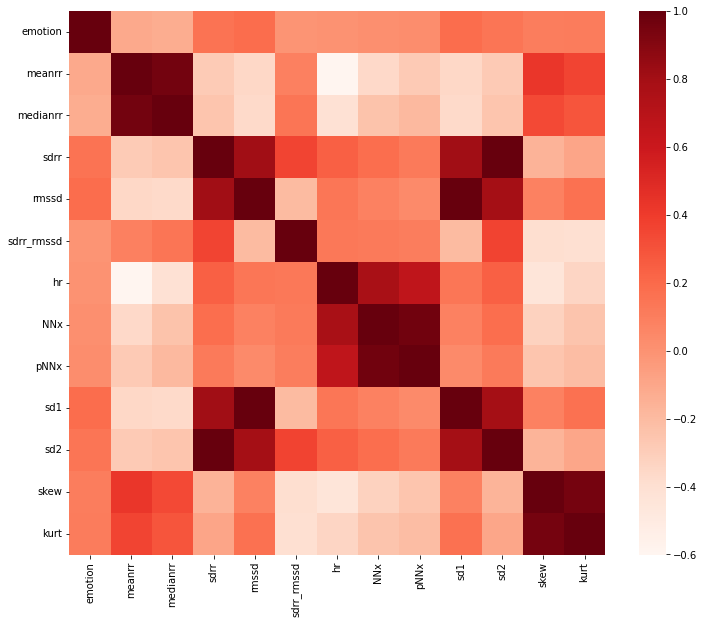

In [34]:
plt.figure(figsize=(12,10))
corr = extract_frame.corr()
sns.heatmap(corr, annot=False, cmap=plt.cm.Reds)
plt.show()

In [35]:
def feature_selection(correlation, threshold):
    selected_features = []
    for i in range(corr.shape[0]):
      if corr.iloc[i,0] > threshold:
        selected_features.append(extract_frame.iloc[:,i])
    return pd.DataFrame(selected_features).T

In [36]:
CORRELATION_THRESHOLD = 0.1
extract_frame = feature_selection(extract_frame, CORRELATION_THRESHOLD)
x = extract_frame.drop(['emotion'],axis=1)
y = extract_frame['emotion']
train_x, test_x, train_y, test_y = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=0)

extract_frame.head()

,emotion,sdrr,rmssd,sd1,sd2,skew,kurt
0,0.0,0.201542,0.066586,0.047107,0.281103,2.898871,10.845686
1,4.0,0.233239,0.085923,0.060787,0.324200,0.875047,3.079515
2,3.0,0.197991,0.062261,0.044048,0.276516,2.842292,11.033996
3,0.0,0.221027,0.072777,0.051486,0.308310,3.158817,12.848869
4,5.0,0.205307,0.064151,0.045385,0.286779,2.862825,11.344312


In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier


dt_model = DecisionTreeClassifier(criterion="entropy", max_depth=12)
dt_model = dt_model.fit(train_x, train_y)
dt_pred_y = dt_model.predict(test_x)

rf_model = RandomForestClassifier()
rf_model.fit(train_x, train_y)
rfpred_y = rf_model.predict(test_x)

In [38]:
print(classification_report(test_y,dt_pred_y))

              precision    recall  f1-score   support

         0.0       0.12      0.25      0.17         4
         1.0       0.33      0.30      0.32        10
         2.0       0.36      0.57      0.44         7
         3.0       0.60      0.52      0.56        23
         4.0       0.50      0.35      0.41        17
         5.0       0.18      0.50      0.27         4
         6.0       0.00      0.00      0.00         8
         7.0       0.00      0.00      0.00         7

    accuracy                           0.35        80
   macro avg       0.26      0.31      0.27        80
weighted avg       0.37      0.35      0.35        80



In [39]:
print(classification_report(test_y,rfpred_y))

              precision    recall  f1-score   support

         0.0       0.33      0.25      0.29         4
         1.0       0.38      0.30      0.33        10
         2.0       0.50      0.57      0.53         7
         3.0       0.50      0.57      0.53        23
         4.0       0.47      0.41      0.44        17
         5.0       0.18      0.50      0.27         4
         6.0       0.00      0.00      0.00         8
         7.0       0.33      0.14      0.20         7

    accuracy                           0.39        80
   macro avg       0.34      0.34      0.32        80
weighted avg       0.39      0.39      0.38        80



In [40]:
#def get_plot_ranges(start=10, end=20, n=5):
    '''
    Make an iterator that divides into n or n+1 ranges. 
    - if end-start is divisible by steps, return n ranges
    - if end-start is not divisible by steps, return n+1 ranges, where the last range is smaller and ends at n
    
    # Example:
    >> list(get_plot_ranges())
    >> [(0.0, 3.0), (3.0, 6.0), (6.0, 9.0)]

    '''
#    distance = end - start
#    for i in np.arange(start, end, np.floor(distance/n)):
#        yield (int(i), int(np.minimum(end, np.floor(distance/n) + i)))

IndentationError: unexpected indent (1596905438.py, line 2)